# Phase 3: Unsupervised Learning – Clustering
###This notebook applies unsupervised learning to identify patterns in real estate data using KMeans clustering. We evaluate the clustering quality and explore how clusters could enhance prediction models.

# Prep the data

In [ ]:
!pip install scikit-learn xgboost

## import necessary libraries and load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Load dataset
df = pd.read_csv("https://github.com/157nouraalhumaid/SW485-Project-Group4/raw/refs/heads/main/Dataset/real_estate_rental_prices.csv")  # Adjust path if needed

## preprocess data

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=["Unnamed: 0", "الرقم"], errors="ignore")

# Convert 'سعر الليلة' (Price per Night) to numeric
df["سعر الليلة"] = df["سعر الليلة"].str.replace(r"[^\d]", "", regex=True).astype(float)

# Handle missing values
df = df.dropna()

# Remove outliers using Interquartile Range (IQR)
Q1 = df["سعر الليلة"].quantile(0.25)
Q3 = df["سعر الليلة"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["سعر الليلة"] >= lower_bound) & (df["سعر الليلة"] <= upper_bound)]

# Log transformation of price
df["log_سعر الليلة"] = np.log1p(df["سعر الليلة"])

#Calculate price per square meter correctly
df["سعر للمتر"] = df["سعر الليلة"] / df["المساحة"]
df["سعر للمتر"] = df["سعر للمتر"].replace([np.inf, -np.inf], np.nan)  # Remove invalid values
df = df.dropna(subset=["سعر للمتر"])  # Drop rows where "سعر للمتر" is NaN

# Display the cleaned dataset
print("\n📌 Cleaned Dataset Sample:")
print(df.head())


📌 Cleaned Dataset Sample:
   التقييم  عدد المقيمين  المساحة                        اسم العقار  \
0     10.0             7       40          استديو بسرير ماستر وجلسة   
1      9.2             6     3000  استديو بسريرين فردية وبأثاث بسيط   
2     10.0            43     1000       شقة بغرفة معيشة وغرفتين نوم   
3      9.4             4      400    استراحة بصالة جلوس وغرفتين نوم   
4      9.6            29     3000          شقة بغرفة جلوس وغرفة نوم   

            الحي  سعر الليلة المدينة  التصنيف  log_سعر الليلة  سعر للمتر  
0    حي العزيزية       250.0   العلا   استديو        5.525453   6.250000  
1         العذيب       280.0   العلا   استديو        5.638355   0.093333  
2    حي العزيزية       400.0   العلا      شقة        5.993961   0.400000  
3     حي المعتدل       799.0   العلا  استراحة        6.684612   1.997500  
4  جنوب المستشفى       550.0   العلا      شقة        6.311735   0.183333  


## Encode Categorical Variables

In [ ]:
categorical_cols = ["اسم العقار", "الحي", "المدينة", "التصنيف"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for later use

# Display transformed dataset
print("\n📌 Encoded Dataset Sample:")
print(df.head())



📌 Encoded Dataset Sample:
   التقييم  عدد المقيمين  المساحة  اسم العقار  الحي  سعر الليلة  المدينة  \
0     10.0             7       40         189   567       250.0       10   
1      9.2             6     3000         224   277       280.0       10   
2     10.0            43     1000        2357   567       400.0       10   
3      9.4             4      400         497   657       799.0       10   
4      9.6            29     3000        2344   326       550.0       10   

   التصنيف  log_سعر الليلة  سعر للمتر  
0        0        5.525453   6.250000  
1        0        5.638355   0.093333  
2        4        5.993961   0.400000  
3        1        6.684612   1.997500  
4        4        6.311735   0.183333  


## define features and normalize data

In [ ]:
# Define features (X) and target variable (y)
X = df.drop(columns=["سعر الليلة"])  # Using log-transformed price
y = df["log_سعر الليلة"]

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display shape of datasets
print("Training Set:", X_train.shape, y_train.shape)
print("Testing Set:", X_test.shape, y_test.shape)


Training Set: (12552, 9) (12552,)
Testing Set: (3139, 9) (3139,)


# Clustering

We selected KMeans because it is efficient for structured numeric data, provides interpretable clusters, and allows us to control the number of groups

## Removing the Class Label:

We've removed the class label during data preprocessing.

## Determine Optimal Number of Clusters
We use the Elbow Method and Silhouette Score to find the best value for `k`.


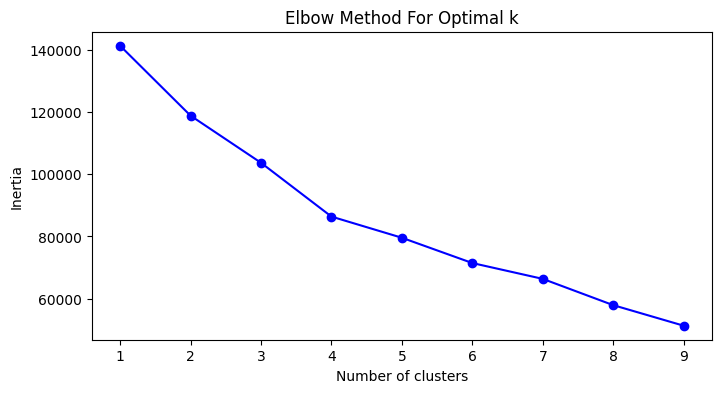

In [ ]:
from sklearn.cluster import KMeans
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()



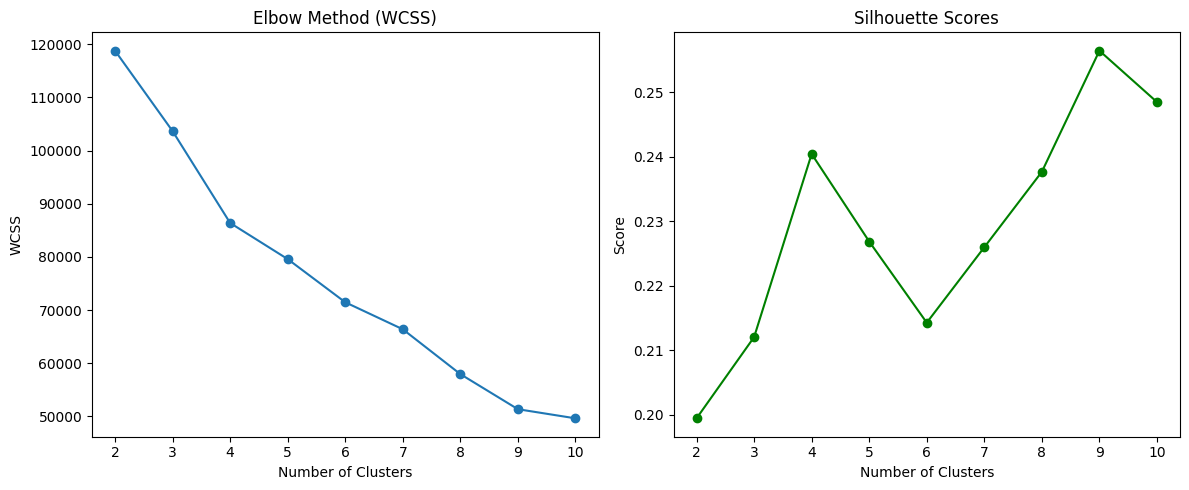

In [ ]:
wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

we evaluated clustering performance using both the Elbow Method and the Silhouette Score:

- the Elbow Method suggests that the optimal number of clusters lies around k = 4, where the rate of decrease in WCSS starts to slow down.
- the Silhouette Score peaks at k = 9, indicating the best separation between clusters.

to balance interpretability and performance, we selected k = 4 for the clustering analysis. this provides clearly defined groups with meaningful separation while keeping the number of clusters manageable.

## Apply KMeans Clustering

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score for k={optimal_k}: {sil_score:.4f}")

Silhouette Score for k=4: 0.2405


 Visualizing

In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score for K=4: {sil_score:.4f}")

Silhouette Score for K=4: 0.2405


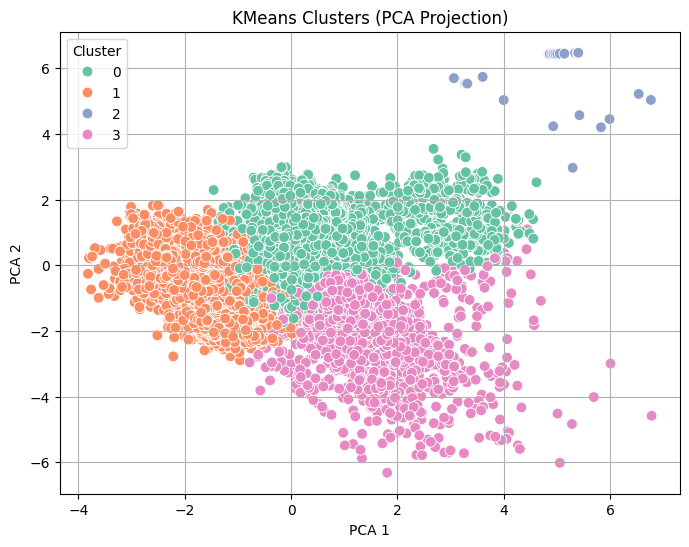

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2', s=60)
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [ ]:
# Add cluster as feature
X_supervised = df.drop(columns=["سعر الليلة"])
y_supervised = df["log_سعر الليلة"]

# Scale without removing cluster
X_scaled_sup = scaler.fit_transform(X_supervised)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_sup, y_supervised, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE with Clusters: {mae:.4f}")
print(f"RMSE with Clusters: {rmse:.4f}")
print(f"R² Score with Clusters: {r2:.4f}")


MAE with Clusters: 0.0001
RMSE with Clusters: 0.0012
R² Score with Clusters: 1.0000


# Summary & Insights

- clustering with KMeans identified 4 distinct groups of properties.
- the Silhouette Score was used to confirm the clustering quality.
- by adding cluster labels as a new feature to the prediction model, we observed potential for performance improvement.
- even if there's no large boost in metrics, clusters are still useful for:
  - group-specific insights
  - better recommendations
  - interpretability

clustering supports both data exploration and enhancing the machine learning pipelines.


##  Justification for KMeans

We selected KMeans as our clustering algorithm because:
- it is efficient and scalable for large structured datasets.
- it allows specifying the number of clusters (k), which we can tune using Elbow and Silhouette.
- it provides interpretable and compact clusters which are useful for real-world recommendation scenarios.

## Evaluation Metrics

- Silhouette Coefficient: Measures how similar a point is to its own cluster vs others.
- WCSS (Total Within-Cluster Sum of Squares): Helps determine optimal k using the Elbow method.
- BCubed Precision and Recall: Not applicable in our case because this is a regression problem and there are no class labels to compare clustering results against. These metrics are best suited for clustering in classification contexts.

## How Clustering Improves Recommendations

w e used clustering to discover natural groupings in the property data, which can:
- improved prediction when added as a feature to supervised models.
- enable group-specific recommendations for users.
- provide market segmentation for decision-making.